In [1]:
import os
path = os.path.abspath(os.getcwd())
print(path)
folder = os.path.split(path)[-1]
if folder == 'Subjects_Scripts':
    print('Subjects_Scripts')
    %run my_imports.py
elif folder == 'MySpaces':
    print('MySpaces')
    %run Subjects_Scripts/my_imports.py

C:\Users\bastien\Documents\Git\python_analysis_2\project\MySpaces\Subjects_Scripts
Subjects_Scripts


In [2]:
# folderSubject = r'D:/DataSet/MySpaces/data/s07/'

In [3]:
folderName = os.path.join(folderSubject,'records','fif','agency')

raws_list,events = load_fif_from_folder(folderName,concatFile=False)

raws = mne.concatenate_raws(raws_list)
events = mne.find_events(raws, stim_channel='TRIGGER', shortest_event = 1)
montageFile = os.path.join(folderAnalysis,'locFile','montageANT64_inverse.txt')
layoutFile  = os.path.join(folderAnalysis,'locFile','antneuro_64ch.lay')
chan_dict_file = os.path.join(folderAnalysis,'locfile','chan_dict_64ANT.txt')

f = open(chan_dict_file,'r')
chan_dict = eval(f.read())
     
cfg= {'spatial_filter': 'CAR',
'montage_file':montageFile,
'layout_file':layoutFile}

scale = dict(mag=1e-12, grad=4e-11, eeg=100, eog=150, ecg=500,
     emg=1e3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1e3, chpi=1e-4, whitened=1e2)

print(raws.ch_names)

if 'AUX3' in raws.ch_names:
    print("1")
    resp_channel = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX3':'resp','M1':'emg','M2':'emg'}
elif 'AUX7' in raws.ch_names:
    print("2")
    resp_channel = "AUX7"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX7':'resp','M1':'emg','M2':'emg'}
elif 'AUX13' in raws.ch_names:
    print("3")
    resp_channel = "AUX13"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX13':'resp','M1':'emg','M2':'emg'}


raws.set_channel_types(mapping_channel_type)
raws = set_montage_from_file(raws,cfg,kind='topomap')

print('[Preprocessing] Preprocessed Data')

print('[Events Visualization] Checking events')
print(np.unique(events[:,2]))
print('[Events Visualization] Define dictionary for epoching')

[Load Data] Found 5 files
['TRIGGER', 'FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCZ', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ', 'AUX1', 'AUX7']
2
[Preprocessing] Preprocessed Data
[Events Visualization] Checking events
[ 10  20  30  40  60  70  99 110 111 112 113 114 115 116 117 118 119]
[Events Visualization] Define dictionary for epoching


# Event Preprocessing 

In [4]:
idx_data_action = np.where(events[:,2] == 30)[0]
print(len(idx_data_action))
trial_remove = []
trialIdx = []
for i,idx_Start in enumerate(idx_data_action):
    if events[idx_Start + 1,2] == 40:
        pass
    else:
        trialIdx.append(i)
        trial_remove.append(idx_Start)
        events[idx_Start-1:idx_Start+2,2] = 0
        
print(trialIdx,trial_remove)

300
[216] [1312]


In [5]:
file = os.path.join(folderName,'pilot_logs.csv')
dataFrame = pd.read_csv(file,header=0)
dataFrame.head()

data_type_frame = dataFrame['trial_type']
data_type = data_type_frame.to_numpy()
data_type = (data_type != 'BMI').astype(int)+1

print(np.shape(data_type))
data_type = np.delete(data_type, trialIdx)
print(np.shape(data_type))

list_Type_trials = dict(cue=2,self=1)
print(list_Type_trials)

(300,)
(299,)
{'cue': 2, 'self': 1}


In [6]:
def min_max_normalization(data):
    return (data - np.nanmin(data))/(np.nanmax(data)-np.nanmin(data))
def zscore_normalization(data):
    return (data - np.nanmean(data))/np.nanstd(data)

In [7]:
agency_rate = dataFrame['agency'].to_numpy()
data_agency = np.zeros(np.shape(agency_rate))
nTrialPerBlock = 60
for i in range(0,len(agency_rate),nTrialPerBlock):
    data_agency_block = agency_rate[i:i+nTrialPerBlock]
    index_remove = np.where(data_agency_block == 0)[0]
    print(index_remove)
    data_agency_block = zscore_normalization(data_agency_block)
    data_agency_block[index_remove] = np.nan
    data_agency[i:i+nTrialPerBlock] = data_agency_block
print('Agency grade normalized an grade 0 set to Nan')

[24 29 48 50]
[ 7 21 37 58]
[ 7 19 34]
[29 34 36 44]
[13 29 35 56]
Agency grade normalized an grade 0 set to Nan


In [8]:
print(np.shape(data_agency))
data_agency = np.delete(data_agency, trialIdx)
print(np.shape(data_agency))

(300,)
(299,)


In [9]:
idx_action_event = np.where(events[:,2] == 40)[0]
idx_go_event = np.where(events[:,2] == 30)[0]
idx_start_event = np.where(events[:,2] == 20)[0]
print(len(idx_start_event),len(idx_go_event),len(idx_action_event))

299 299 299


In [10]:
epochs  = mne.Epochs(raws, events, event_id=40,
                         tmin=-1.5, tmax=0.5,baseline=None, preload = True)
print(epochs)

<Epochs  |   299 events (all good), -1.5 - 0.5 sec, baseline off, ~156.8 MB, data loaded,
 '40': 299>


# Compute Probabilities

In [18]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.0.


In [19]:
import pycnbi
from pycnbi.utils import q_common as qc


folderClassifier = os.path.join(folderSubject,'records','fif','classifier')
fileClassifier = os.path.join(folderClassifier,'classifier-64bit.pkl')

classifier = qc.load_obj(fileClassifier)
print(classifier.keys())


dict_keys(['cls', 'ch_names', 'psde', 'sfreq', 'picks', 'classes', 'epochs', 'w_frames', 'w_seconds', 'wstep', 'spatial', 'spatial_ch', 'spectral', 'spectral_ch', 'notch', 'notch_ch', 'multiplier', 'ref_ch', 'decim'])


In [20]:
import pycnbi.utils.pycnbi_utils as pu
import sys

prob_trial = []
wlen = int(classifier['sfreq']*classifier['w_seconds'])
wstep = int(classifier['sfreq']/classifier['wstep'])
probs_trials_list = []
listEventOfInterest = {'ACTION_SELF':40}
epochs  = mne.Epochs(raws, events, event_id=listEventOfInterest,
                         tmin=-1, tmax=0.2,baseline=None, preload = True)
print(len(epochs.times))
nEpoch,nChan,nSample = np.shape(epochs._data)

try:
    for iEpoch in range(nEpoch):
        this_epoch = epochs._data[iEpoch,:,:]
        sys.stdout.write('\rTrial: '+str(iEpoch) + '/'+ str(nEpoch))
        sys.stdout.flush()
        prob_trial = np.zeros((nSample,1))
        for iWindow in range(wlen,nSample,wstep):
            
            w = this_epoch[:,iWindow-wlen:iWindow]
        
            # psd = channels x freqs
      
            w = pu.preprocess(w, sfreq=classifier['sfreq'], spatial=classifier['spatial'], spatial_ch=classifier['spatial_ch'],
                           spectral=classifier['spectral'], spectral_ch=classifier['spectral_ch'], notch=classifier['notch'],
                           notch_ch=classifier['notch_ch'], multiplier=classifier['multiplier'], decim=classifier['decim'])
            w = w[classifier['picks']]
            psd = classifier['psde'].transform(w.reshape((1, w.shape[0], w.shape[1])))
                                               
            # make a feautre vector and classify
            feats = np.concatenate(psd[0]).reshape(1, -1)

            # compute likelihoods
            probs = classifier['cls'].predict_proba(feats)[0]
            prob_trial[iWindow-wstep:iWindow,:] = probs[0]
        probs_trials_list.append(prob_trial)
    print('Probabilities Computed')

except:
    for iEpoch in range(nEpoch):
        this_epoch = epochs._data[iEpoch,:,:]
        sys.stdout.write('\rTrial: '+str(iEpoch) + '/'+ str(nEpoch))
        sys.stdout.flush()
        prob_trial = np.zeros((nSample,1))
        for iWindow in range(wlen,nSample,wstep):
            w = this_epoch[:,iWindow-wlen:iWindow]
        
            # psd = channels x freqs
      
            w = pu.preprocess(w, sfreq=classifier['sfreq'], spatial=classifier['spatial'], spatial_ch=classifier['spatial_ch'],
                           spectral=classifier['spectral'], spectral_ch=classifier['spectral_ch'], notch=classifier['notch'],
                           notch_ch=classifier['notch_ch'], multiplier=classifier['multiplier'], decim=classifier['decim'])
            w = w[classifier['picks']]
            psd = classifier['psde'].transform(w.reshape((1, w.shape[0], w.shape[1])))
                                               
            # make a feautre vector and classify
            feats = np.concatenate(psd[0]).reshape(1, -1)

            # compute likelihoods
            probs = classifier['cls'].predict_proba(feats)[0]
            prob_trial[iWindow-wstep:iWindow,:] = probs[0]
        probs_trials_list.append(prob_trial)
    print('Probabilities Computed')

615
Trial: 298/299Probabilities Computed


In [21]:
index = np.where(epochs.times == 0)[0][0]
prob_action = [prob[index][0] for prob in probs_trials_list]
print(np.shape(prob_action))

(299,)


In [22]:
agency_dict  = {'probs': prob_action, 'agency_rate': data_agency,'type_trial':data_type}
df_agency = pd.DataFrame(agency_dict)
df_agency.head(4)

probs  agency_rate  type_trial
0  0.623072    -0.204756           2
1  0.319766    -1.149785           2
2  0.627371     0.267758           2
3  0.726877    -1.622299           1

In [23]:
import seaborn as sns

nbins = 6
fig= plt.figure(figsize=(12, 4))
iplot = 0

bins = np.linspace(np.nanmin(data_agency), np.nanmax(data_agency), nbins)
ind = np.digitize(data_agency, bins)
df_agency['bin'] = ind
    
for key,item in list_Type_trials.items():
    print(key,item)
    df = df_agency[df_agency['type_trial'] == item]
    axs=fig.add_subplot(121+iplot)
    g=sns.boxplot(x='bin', y='probs', data=df,width=0.8,linewidth=2,showfliers = True)
    g.set(title=key,xlim=[-1,nbins])
    iplot +=1

cue 2
self 1


In [24]:
listEventOfInterest = {'ST_ACTION_SELF':40}

# Amplitude
raw_filter = raws.copy()
picks_RESP = raw_filter.ch_names.index(resp_channel)
resp_data = np.squeeze(raw_filter.get_data(picks=picks_RESP))
sfreq = raw_filter.info['sfreq']
transient_change = mne.filter.filter_data(resp_data,sfreq=sfreq,l_freq=0.1,h_freq=10)
transient_change = np.reshape(transient_change, (-1, 1)).T 
info = mne.create_info(['AUX3filter'], raws.info['sfreq'], ['ecg'])
stim_raw = mne.io.RawArray(transient_change, info)
raw_filter.add_channels([stim_raw], force_update_info=True)

# Need to inverse that data because of ANTneuro
raw_filter._data = -1*raw_filter._data

epochs_amplitude_resp = mne.Epochs(raw_filter, events, event_id=listEventOfInterest,
                     tmin=-1, tmax=1,baseline=(None), preload = True)

# Phase
raw_hilb = raw_filter.copy()
picks_resp=raw_filter.ch_names.index("AUX3filter")
raw_hilb.apply_hilbert(picks_resp)
raw_phase = raw_hilb.copy()
raw_phase.apply_function(np.angle,picks_resp)

epochs_phase  = mne.Epochs(raw_phase, events, event_id=listEventOfInterest,
                         tmin=-2, tmax=2,baseline=None, preload = True)

print(epochs_phase)

<Epochs  |   299 events (all good), -2 - 2 sec, baseline off, ~635.9 MB, data loaded,
 'ST_ACTION_SELF': 299>


cue 2
200
(200,)
(200,)
self 1
99
(99,)
(99,)


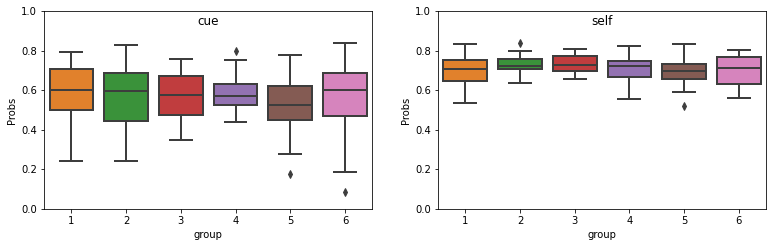

In [43]:
import seaborn as sns
import pandas as pd
from utils.utils_normalization import zscore_over_trials

fig = plt.figure(figsize=(20,8))
picks_respfiltered = raw_filter.ch_names.index("AUX3filter")
df_probs = dict()
nbins = 7
bins = np.linspace(-np.pi, np.pi, nbins)
iplot = 0

for key,item in list_Type_trials.items():
    print(key,item)
    items_idx = (df_agency['type_trial'] == item).to_numpy()*1
    print(np.sum(items_idx))
    
    index = np.where(epochs_phase.times == 0)[0][0]
        
    iplot +=1
    # phase respiration
    data_resp_event = np.squeeze(epochs_phase.get_data(picks=picks_respfiltered)).real
    data_resp_event = data_resp_event[items_idx==1,index]
    print(np.shape(data_resp_event))
    
    ind = np.digitize(data_resp_event, bins)
 
    # probs
    data_mu = df_agency[df_agency['type_trial'] == item]['probs'].to_numpy()
    print(np.shape(data_mu))    
    power_phase = []
    resp_phase = []
    df = pd.DataFrame()
    for iBin in range(nbins):
        a = data_mu * np.array(ind==iBin).astype(int)
        a[a==0] = np.nan
        power_phase.append(a)
    for iPhase,this_phase in enumerate(power_phase):
        pmu_trial = this_phase
        a = pd.DataFrame({ 'group' : np.repeat(iPhase,len(pmu_trial)), 'Probs': pmu_trial})
        df = df.append(a)
        
    df_probs.update({key:df})
        
    # Plotting
    axs=fig.add_subplot(230+iplot)
    ax = sns.boxplot(x='group', y='Probs', data=df,width=0.8,linewidth=2,showfliers = True)
    ax.set_title(key,y=0.9)
    axs.set_xlim([0.5,nbins-0.5])
    axs.set_ylim([0,1])

In [ ]:
saving_var('df_agency',folderSubject,df_agency)
saving_var('prob_trials',folderSubject,probs_trials_list)
saving_var('df_probs',folderSubject,df_probs)